In [651]:
from collections import defaultdict
import requests
import time, os

import numpy as np
import pandas as pd

import json, urllib3, string
from bs4 import BeautifulSoup

import pickle
from sqlalchemy import create_engine

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from IPython.display import Image
import matplotlib.pylab as pylab
from matplotlib.ticker import PercentFormatter

import re

import gender_guesser.detector as gender

import statsmodels.api as sm
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split

## Load Pickle'd Data

Pickle

In [12]:
with open('datasets_dict.pickle', 'rb') as f:
    datasets_dict = pickle.load(f)

print("Loaded datasets:",list(datasets_dict.keys()))
datasets_dict

Loaded datasets: ['merge', 'principals_names', 'id_directors', 'id_writers']


{'merge':         imdbid                                   title    id  year  rating  \
 0      0392728                   Roundhay Garden Scene  8040  1888       0   
 1      0000003                          Pauvre Pierrot  5433  1892       0   
 2      0132134  Execution of Mary, Queen of Scots, The  6200  1895       0   
 3      0000014           Tables Turned on the Gardener  5444  1895       0   
 4      0000131                       Une nuit terrible  5406  1896       0   
 ...        ...                                     ...   ...   ...     ...   
 8776   7178640                       Superintelligence  9421  2020       3   
 8777   8299768                       Blow the Man Down  9079  2020       3   
 8778   8522006                         Happiest Season  9395  2020       3   
 8779  10243992                      I&#39;m Your Woman  9437  2020       3   
 8780   6587640                       Trolls World Tour  9087  2020       3   
 
        imdbid_tt      tconst            

In [ ]:
merge = datasets_dict['merge']
principals_names = datasets_dict['principals_names']
id_directors = datasets_dict['id_directors']
id_writers = datasets_dict['id_writers']

In [718]:
len(merge)

8781

In [717]:
merge['year'].describe()

count    8781.000000
mean     1996.498121
std        23.497180
min      1888.000000
25%      1989.000000
50%      2006.000000
75%      2013.000000
max      2020.000000
Name: year, dtype: float64

#### Production Company Identification

Scraped production company

In [356]:
def get_production_companies(movie_id):
#     print(movie_id)
    movie = ia.get_movie(movie_id)
    if 'production companies' in movie.keys():
        series = pd.Series(pd.Series(movie['production companies']).unique()).apply(lambda x:x['name']) + ","
        result = series.sum()
    else:
        result = 'error'
    return result


In [ ]:
# %%time
# # create an instance of the IMDb class
# ia = IMDb()

In [368]:
# # test
# merge['production companies'] = merge['imdbid'][:5].apply(get_production_companies)

# # entire data
# merge['production companies'] = merge['imdbid'].apply(get_production_companies)
# merge['production companies'] = merge['production companies'].str.replace(",$","")


Pickling

In [ ]:
# id_prod_comps = pd.DataFrame(merge['production companies'].str.split(',').tolist(),index=merge['imdbid_tt']).stack()
# id_prod_comps = id_prod_comps.reset_index([0,'imdbid_tt'])
# id_prod_comps.columns = ['imdbid_tt','production companies']
# with open('id_prod_comps.pickle', 'wb') as f:
#     pickle.dump(id_prod_comps, f, protocol=4)

#### Flagging Top Production Companies, Producers, Directors

Load pickle'd data and continue data processing

In [ ]:
with open('id_prod_comps.pickle', 'rb') as f:
    id_prod_comps = pickle.load(f)

Bechdel pass rate by production company

In [603]:
prod_comp_bechdel = id_prod_comps.merge(merge[['imdbid_tt','rating']],on='imdbid_tt',how='left')
prod_comp_bechdel['bechdel pass'] = 0
prod_comp_bechdel.loc[prod_comp_bechdel['rating'] == 3,'bechdel pass'] = 1

groupby = prod_comp_bechdel[prod_comp_bechdel['production companies']!='error'].groupby('production companies').agg({'bechdel pass':['sum','count']}).reset_index()
groupby['% of Movies Passing Bechdel Test'] = groupby['bechdel pass']['sum']/groupby['bechdel pass']['count']
groupby['count'] = groupby['bechdel pass']['count']
top_prod_comp_bechdel = groupby.sort_values(by='count',ascending=False).head(50)
top_prod_comp_bechdel.to_csv("Top Production Companies' Movies Rates of Passing the Bechdel Test.csv")

groupby.sort_values(by='count',ascending=False).head(10)

production companies bechdel pass        \
                                                              sum count   
9371                                    Warner Bros.          188   394   
9117                              Universal Pictures          188   345   
6635                              Paramount Pictures          160   302   
2077                               Columbia Pictures          141   294   
1548                                          Canal+          163   263   
8988                           Twentieth Century Fox          141   255   
9357                            Walt Disney Pictures          100   173   
5747                       Metro-Goldwyn-Mayer (MGM)           83   159   
6165                                 New Line Cinema           98   155   
1684  Centre National du Cinéma et de l'Image Animée           76   123   

     % of Movies Passing Bechdel Test count  
                                             
9371                         0.477157   394  
9117                         0.544928   345  
6635                         0.529801   302  
2077                         0.479592   294  
1548                         0.619772   263  
8988                         0.552941   255  
9357                         0.578035   173  
5747                         0.522013   159  
6165                         0.632258   155  
1684                         0.617886   123

Flagging Top Production Companies

In [637]:
# Load flagged data
top_prod_comps_bechdel_w_flag = pd.read_csv('Top Production Companies with Ex-US Flags.csv')

prod_comps_counts = id_prod_comps[id_prod_comps['production companies']!='error']['production companies'].value_counts().reset_index()
prod_comps_counts.columns = ['production companies','movie count']
top_n = 50
top_prod_comps = prod_comps_counts.iloc[:top_n]
top_prod_comps = id_prod_comps.merge(top_prod_comps['production companies'],on='production companies',how='left',indicator='top flag')
top_prod_comps = top_prod_comps.merge(top_prod_comps_bechdel_w_flag[['production companies','Ex-US']],on='production companies',how='outer')
top_prod_comps[top_prod_comps['top flag'] == 'both'].sample(n=5)

,imdbid_tt,production companies,top flag,Ex-US
1775,tt0448157,Columbia Pictures,both,0.0
10061,tt2974918,Fox 2000 Pictures,both,0.0
2428,tt0068815,Toho Company,both,1.0
5568,tt5074352,Walt Disney Pictures,both,0.0
445,tt1980209,Paramount Pictures,both,0.0


In [638]:
# keep imdbid's that merged and deduplicate
has_top_prod_comp = top_prod_comps[top_prod_comps['top flag'] == 'both'].groupby('imdbid_tt').sum().reset_index()
has_top_prod_comp.loc[has_top_prod_comp['Ex-US']>0,'Ex-US'] = 1 
has_top_prod_comp['has top prod comp'] = 1
has_top_prod_comp = has_top_prod_comp.rename(columns={'Ex-US':'Ex-US and Top Prod Comp'})
has_top_prod_comp.sample(n=5)

,imdbid_tt,Ex-US and Top Prod Comp,has top prod comp
365,tt0062852,1.0,1
691,tt0097576,0.0,1
3021,tt2218003,0.0,1
1406,tt0253754,0.0,1
1865,tt0422015,1.0,1


#### Gender identification

In [396]:
# Intialize gender guesser 
d = gender.Detector()

In [397]:
listofnamesandids = principals_names.groupby(['nconst','firstName']).size()
listofnamesandids = listofnamesandids.reset_index().drop(columns=0)
listofnamesandids.head()

,nconst,firstName
0,nm0000001,Fred
1,nm0000002,Lauren
2,nm0000003,Brigitte
3,nm0000004,John
4,nm0000005,Ingmar


In [398]:
listofnamesandids['gender'] = listofnamesandids['firstName'].apply(d.get_gender)
listofnamesandids.head()

,nconst,firstName,gender
0,nm0000001,Fred,male
1,nm0000002,Lauren,mostly_female
2,nm0000003,Brigitte,female
3,nm0000004,John,male
4,nm0000005,Ingmar,male


In [399]:
id_directors['gender'] = id_directors['firstName'].apply(d.get_gender)
id_directors.head()

,imdbid_tt,directors,nconst,primaryName,firstName,gender
0,tt0392728,nm1284117,nm1284117,Louis Aimé Augustin Le Prince,Louis,male
1,tt0000003,nm0721526,nm0721526,Émile Reynaud,Émile,unknown
2,tt0132134,nm0163632,nm0163632,Alfred Clark,Alfred,male
3,tt0000014,nm0349785,nm0349785,Alice Guy,Alice,female
4,tt0223341,nm0349785,nm0349785,Alice Guy,Alice,female


In [400]:
id_writers['gender'] = id_writers['firstName'].apply(d.get_gender)
id_writers.head()

,imdbid_tt,writers,nconst,primaryName,firstName,gender
0,tt0223341,nm0349785,nm0349785,Alice Guy,Alice,female
1,tt0000091,nm0617588,nm0617588,Georges Méliès,Georges,male
2,tt0000211,nm0617588,nm0617588,Georges Méliès,Georges,male
3,tt0131934,nm0617588,nm0617588,Georges Méliès,Georges,male
4,tt0000417,nm0617588,nm0617588,Georges Méliès,Georges,male


In [401]:
principals_gender_eda = principals_names.copy()
principals_gender_eda = principals_gender_eda.merge(listofnamesandids[['nconst','gender']],on='nconst',how='inner',validate="m:1")
principals_gender_eda.loc[principals_gender_eda['category']=='actor','gender'] = 'male'
principals_gender_eda.loc[principals_gender_eda['category']=='actress','gender'] = 'female'
principals_gender_eda.loc[principals_gender_eda['category'].isin(['actor','actress']),'category'] = 'cast'
principals_gender_eda = principals_gender_eda.groupby(['imdbid_tt','category','gender']).count().reset_index()

directors_gender_eda = id_directors.groupby(['imdbid_tt','gender']).count().reset_index()
writers_gender_eda = id_writers.groupby(['imdbid_tt','gender']).count().reset_index()

principals_gender_eda_graph = principals_gender_eda.groupby(['category','gender']).sum().reset_index()

directors_gender_eda_graph = directors_gender_eda.groupby('gender').sum().reset_index()
writers_gender_eda_graph = writers_gender_eda.groupby('gender').sum().reset_index()

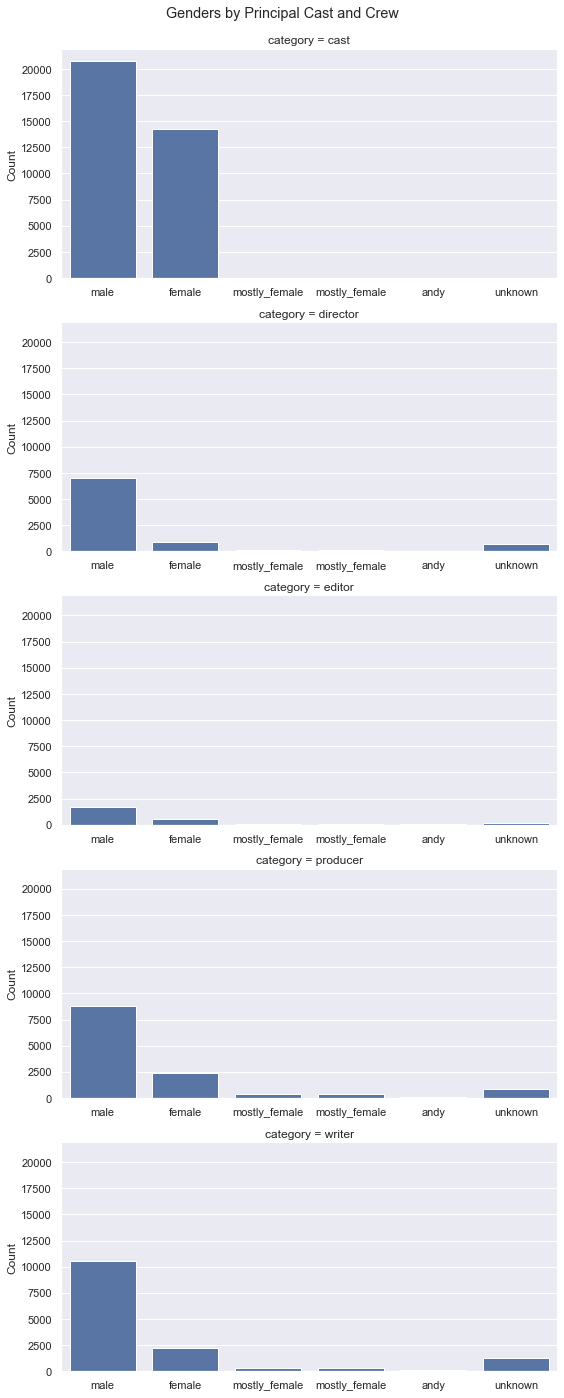

In [402]:
params = {
#          'figure.figsize': (15, 30),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
          
pylab.rcParams.update(params)

sns.set(font_scale=1)

g = sns.FacetGrid(principals_gender_eda_graph, row ='category', sharex=False,height=4,aspect=2)
g.map(sns.barplot,'gender','id',order=['male','female','mostly_female','mostly_female','andy','unknown']);
g.set_axis_labels(y_var='Count',x_var='')
g.fig.subplots_adjust(top=0.95)                     
g.fig.suptitle('Genders by Principal Cast and Crew');

In [403]:
def plot_gender_eda(gender_eda_df, title=None):
    
    params = {
    #          'figure.figsize': (15, 30),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}

    pylab.rcParams.update(params)
    
    g = sns.barplot(data=gender_eda_df,x='gender',y='firstName',order=['male','female','mostly_female','mostly_female','andy','unknown'],color='b')
    g.set(ylabel='Count',xlabel='Gender')
    g.set(title=title)
    return g

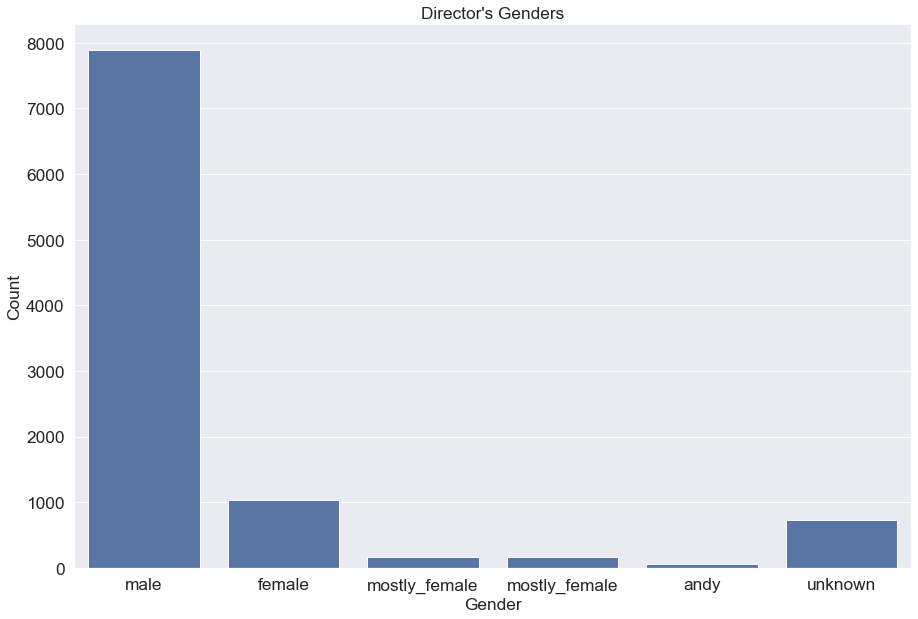

In [404]:
directors_genders = plot_gender_eda(directors_gender_eda_graph,'Director\'s Genders')

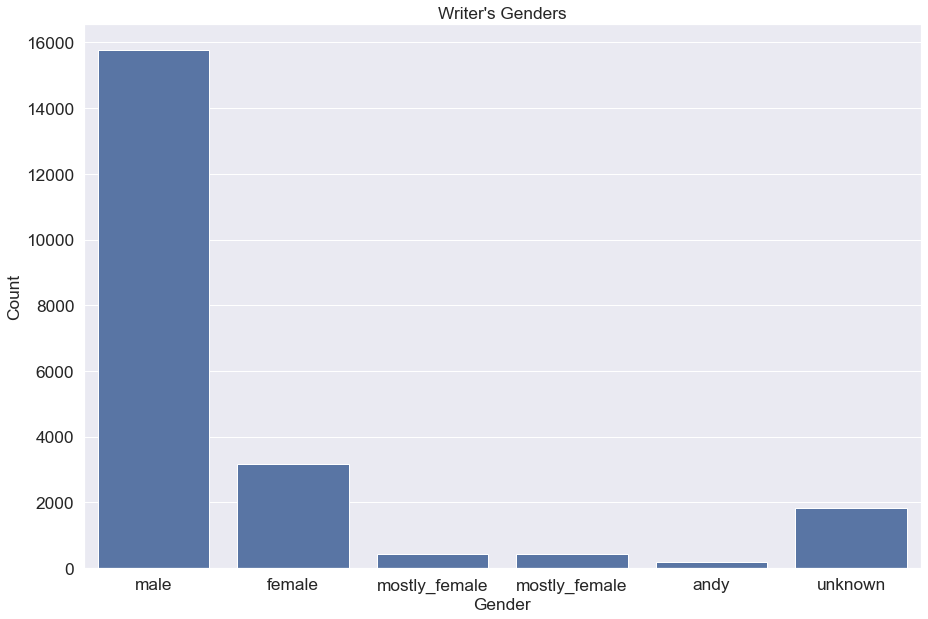

In [405]:
writers_genders = plot_gender_eda(writers_gender_eda_graph,'Writer\'s Genders')

Generate counts for each dataset

In [530]:
principals_counts = principals_gender_eda.groupby(['imdbid_tt','category','gender']).count()
principals_counts = principals_counts['primaryName'].unstack(level='gender').reset_index().fillna(0)
principals_counts['_f_count'] = principals_counts['female'] + principals_counts['mostly_female']
principals_counts['_m_count'] = principals_counts['male'] + principals_counts['mostly_male']
principals_counts['_total_count'] = principals_counts['_m_count'] + principals_counts['_f_count'] \
                                + principals_counts['andy'] + principals_counts['unknown']
principals_counts['_unknown'] = 0
principals_counts.loc[principals_counts['_total_count'] == principals_counts['andy'] + principals_counts['unknown'],'_unknown'] = 1

principals_counts = pd.pivot_table(principals_counts,
                                   values=['_f_count','_m_count','_total_count','_unknown'],
                                   index=['imdbid_tt'] ,
                                   columns='category'
                                  ).reset_index().fillna(0)
principals_counts.columns = ['%s%s' % (b, a) for a, b in principals_counts.columns]
principals_counts = principals_counts.reindex(sorted(principals_counts.columns),axis=1)

# reorder imdbid_tt to front of df
cols = principals_counts.columns.tolist()
col_index = cols.index('imdbid_tt')
cols = [cols[col_index]] + cols[:col_index] + cols[col_index+1:]

principals_counts = principals_counts[cols] 
principals_counts.head()

,imdbid_tt,cast_f_count,cast_m_count,cast_total_count,cast_unknown,director_f_count,director_m_count,director_total_count,director_unknown,editor_f_count,...,editor_total_count,editor_unknown,producer_f_count,producer_m_count,producer_total_count,producer_unknown,writer_f_count,writer_m_count,writer_total_count,writer_unknown
0,tt0000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,tt0000012,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0000014,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0000041,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,tt0000091,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [531]:
director_counts = id_directors.groupby(['imdbid_tt','gender']).count()

director_counts = director_counts['primaryName'].unstack(level='gender').reset_index().fillna(0)
director_counts['director_f_count'] = director_counts['female'] + director_counts['mostly_female']
director_counts['director_m_count'] = director_counts['male'] + director_counts['mostly_male']
director_counts['director_total_count'] = director_counts['director_m_count'] + director_counts['director_f_count'] \
                                + director_counts['andy'] + director_counts['unknown']
director_counts['unknown_dir_flag'] = 0
director_counts.loc[director_counts['director_total_count'] == director_counts['andy'] + director_counts['unknown'],'unknown_dir_flag'] = 1
director_counts = director_counts[['imdbid_tt','director_f_count','director_m_count','director_total_count','unknown_dir_flag']]
director_counts.head()

gender,imdbid_tt,director_f_count,director_m_count,director_total_count,unknown_dir_flag
0,tt0000003,0.0,0.0,1.0,1
1,tt0000012,0.0,2.0,2.0,0
2,tt0000014,1.0,1.0,2.0,0
3,tt0000041,0.0,1.0,1.0,0
4,tt0000091,0.0,1.0,1.0,0


In [532]:
writer_counts = id_writers.groupby(['imdbid_tt','gender']).count()

writer_counts = writer_counts['primaryName'].unstack(level='gender').reset_index().fillna(0)
writer_counts['writer_f_count'] = writer_counts['female'] + writer_counts['mostly_female']
writer_counts['writer_m_count'] = writer_counts['male'] + writer_counts['mostly_male']
writer_counts['writer_total_count'] = writer_counts['writer_m_count'] + writer_counts['writer_f_count'] \
                                + writer_counts['andy'] + writer_counts['unknown']
writer_counts['unknown_wri_flag'] = 0
writer_counts.loc[writer_counts['writer_total_count'] == writer_counts['andy'] + writer_counts['unknown'],'unknown_wri_flag'] = 1
writer_counts = writer_counts[['imdbid_tt','writer_f_count','writer_m_count','writer_total_count','unknown_wri_flag']]
writer_counts.head()

gender,imdbid_tt,writer_f_count,writer_m_count,writer_total_count,unknown_wri_flag
0,tt0000091,0.0,1.0,1.0,0
1,tt0000211,0.0,1.0,1.0,0
2,tt0000230,0.0,1.0,1.0,0
3,tt0000306,0.0,1.0,1.0,0
4,tt0000413,0.0,1.0,1.0,0


Merge count data to master movie data to create modelling dataset

In [533]:
def update_counts(df,var):
    """
    Takes in the dataset of merged 'writer' and 'director' data and
    updates the counts based on the 'principals' data
    """
    new_df = df.copy()
    for suffix in ['_f_count','_m_count','_total_count']:
        final_varname = var + suffix
        _x = final_varname + "_x"
        _y = final_varname + "_y"
        changed = var+'changed'
        new_df[final_varname] = new_df[_x]
        new_df.loc[new_df[_x]<new_df[_y],final_varname] = new_df[_y]
        new_df[changed] = 0
        new_df.loc[new_df[_x]<new_df[_y],changed] = 1
        new_df = new_df.drop(columns=[_x,_y,changed]) # can keep the changed column if we want to see which rows were changed
    return new_df

Modelling dataset creation here:

In [550]:
merge_director = merge.merge(director_counts,on='imdbid_tt',how='inner',validate='m:1')
merge_director_writer = merge_director.merge(writer_counts,on='imdbid_tt',how='inner',validate='m:1')

In [679]:
def add_female_flags(df,category):
    """
    take in model_principals dataset and add flags for 
    varying buckets of presence of women
    """
    my_df=df.copy()
    pct_col = category + "_f_percent"
    count_col = category + "_f_count"
    flag_col = category + "_female_flag"
    my_df.loc[my_df[pct_col]==0,flag_col] = 'No women'
    my_df.loc[my_df[count_col]>=1,flag_col] = 'Has 1 woman'
    my_df.loc[my_df[count_col]>=2,flag_col] = 'Has 2+ women'
    my_df.loc[my_df[pct_col]==1,flag_col] = 'Are only women'
    return my_df

In [697]:
model_principals = merge_director_writer.merge(principals_counts,on='imdbid_tt',how='inner')
model_principals = update_counts(model_principals,'writer')
model_principals = update_counts(model_principals,'director')

# # Investigating discrepancies between directors/writers dataset and principals dataset
# mask1 = model_principals['unknown_dir_flag'] == 1
# mask2 = model_principals['director_unknown'] == 0
# mask3 = model_principals['unknown_dir_flag'] != model_principals['director_unknown']
# model_principals[mask3][['imdbid_tt','directors','unknown_dir_flag','director_unknown','director_f_count','director_m_count','director_total_count']]
# mask1 = model_principals['unknown_wri_flag'] == 1
# mask2 = model_principals['writer_unknown'] == 0
# mask3 = model_principals['unknown_wri_flag'] != model_principals['writer_unknown']
# model_principals[mask3][['imdbid_tt','writers','unknown_wri_flag','writer_unknown','writer_f_count','writer_m_count','writer_total_count']]

model_principals['director_unknown'] = model_principals['unknown_dir_flag']
model_principals['writer_unknown'] = model_principals['unknown_wri_flag']
model_principals = model_principals.drop(columns=['unknown_dir_flag','unknown_wri_flag'])

# keep only names that have their genders known
model_principals= model_principals[model_principals['cast_unknown']
                                    + model_principals['director_unknown']
                                    + model_principals['editor_unknown']
                                    + model_principals['producer_unknown']
                                    + model_principals['writer_unknown'] == 0]

# create target variable
model_principals['bechdel pass'] = 0
model_principals.loc[model_principals['rating'] == 3,'bechdel pass'] = 1

model_principals['writer_f_percent'] = model_principals['writer_f_count'] / model_principals['writer_total_count'] 
model_principals['director_f_percent'] = model_principals['director_f_count'] / model_principals['director_total_count']

# Not every movie has a producer, editor, etc. listed - cannot produce share of females present in each role
# model_principals['producer_f_percent'] = model_principals['producer_f_count'] / model_principals['producer_total_count']
# model_principals['editor_f_percent'] = model_principals['editor_f_count'] / model_principals['editor_total_count']
# model_principals['cast_f_percent'] = model_principals['cast_f_count'] / model_principals['cast_total_count']

model_principals['decade'] = (model_principals['year']//10)*10
model_principals = model_principals.join(pd.get_dummies(model_principals['decade'],drop_first=True))

# Deduplicate
model_principals = model_principals.sort_values(by=['imdbid_tt','year'],ascending=[True,False])
model_principals = model_principals.drop_duplicates(subset='imdbid_tt',keep='first')

# flag buckets for the presence of women in cast/crew
model_principals = add_female_flags(model_principals,'writer') # creates writer_female_flag

model_principals.loc[(model_principals['producer_f_count']>1)&(model_principals['producer_total_count']>0)
                     ,'producer_female_flag'] = 'Has at least 1 woman'
model_principals.loc[(model_principals['producer_f_count']==0)&(model_principals['producer_total_count']>0)
                     ,'producer_female_flag'] = 'No women'

model_principals['director_female_flag'] = 'Has at least 1 woman' # director_female_flag
model_principals.loc[model_principals['director_f_percent']==0,'director_female_flag'] = 'No women'

# merge 'has top ...' flags
model_principals = model_principals.merge(has_top_prod_comp,on='imdbid_tt',how='left',validate='1:1').fillna(0)

print(len(model_principals))

7666


Pickle

In [698]:
with open('model_principals.pickle', 'wb') as f:
    pickle.dump(model_principals, f, protocol=4)

In [778]:
model_principals[(model_principals['writer_female_flag'] == 'Are only women')&(model_principals['bechdel pass'] == 0)]

,imdbid,title,id,year,rating,imdbid_tt,tconst,directors,writers,production companies,...,1980,1990,2000,2010,2020,writer_female_flag,producer_female_flag,director_female_flag,Ex-US and Top Prod Comp,has top prod comp
11,0003424,Suspense,5915,1913,0,tt0003424,tt0003424,"nm0806565,nm0916665",nm0916665,Rex Motion Picture Company,...,0,0,0,0,0,Are only women,0,Has at least 1 woman,0.0,0.0
47,0015174,Kriemhild&#39;s Revenge,1338,1924,2,tt0015174,tt0015174,nm0000485,nm0902376,"Decla-Bioscop AG,Universum Film",...,0,0,0,0,0,Are only women,0,No women,0.0,0.0
53,0015532,Die Abenteuer des Prinzen Achmed,5974,1926,1,tt0015532,tt0015532,"nm0002569,nm0718201",nm0718201,Comenius-Film GmbH,...,0,0,0,0,0,Are only women,0,Has at least 1 woman,0.0,0.0
218,0028356,These Three,7227,1936,2,tt0028356,tt0028356,nm0943758,nm0375484,The Samuel Goldwyn Company,...,0,0,0,0,0,Are only women,No women,No women,0.0,0.0
388,0037514,Anchors Aweigh,6017,1945,0,tt0037514,tt0037514,"nm0360253,nm0053484,nm0796645","nm0501973,nm0545731","Metro-Goldwyn-Mayer (MGM),Loew's",...,0,0,0,0,0,Are only women,No women,No women,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7354,5791884,Ne gledaj mi u pijat,8018,2016,1,tt5791884,tt5791884,nm4080010,nm4080010,"Kinorama,Beofilm,Croatian Audiovisual Centre",...,0,0,0,1,0,Are only women,0,Has at least 1 woman,0.0,0.0
7454,6511932,"Beach Bum, The",9219,2019,1,tt6511932,tt6511932,nm0005101,nm0005101,"Iconoclast,Anonymous Content,Grisbi Production...",...,0,0,0,1,0,Are only women,No women,Has at least 1 woman,0.0,0.0
7471,6738136,Revenge,7839,2017,0,tt6738136,tt6738136,nm0267287,nm0267287,"M.E.S. Productions,Monkey Pack Films,Charades,...",...,0,0,0,1,0,Are only women,No women,Has at least 1 woman,1.0,1.0
7481,6841122,Summerland,9310,2020,1,tt6841122,tt6841122,nm7328140,nm7328140,"Iota Films,Shoebox Films",...,0,0,0,0,1,Are only women,No women,Has at least 1 woman,0.0,0.0


## EDA

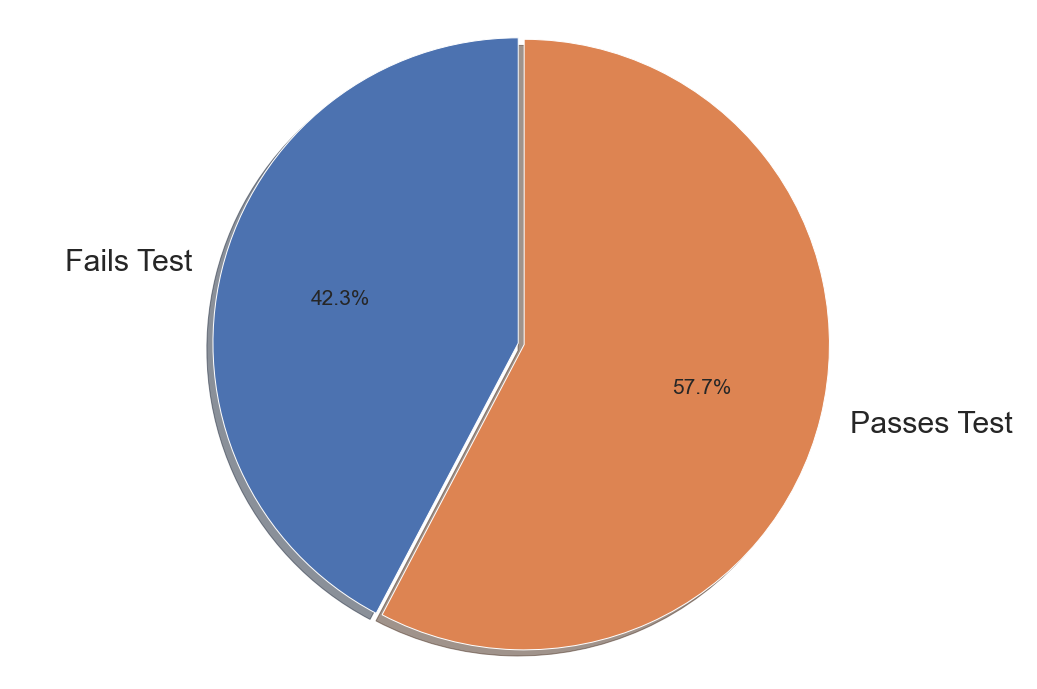

In [715]:
merge['bechdel pass'] = 'Fails Test'
merge.loc[merge['rating'] == 3,'bechdel pass'] = 'Passes Test'
pie_data = merge.groupby('bechdel pass').count().reset_index()

params = {'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

fig1, ax1 = plt.subplots()
ax1.pie(pie_data['imdbid'], labels=pie_data['bechdel pass'], explode = [0.01,0.01], autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  
plt.tight_layout()
plt.savefig("Overall Bechdel Test Rate.svg", format="svg")
plt.show()


In [771]:
def plot_pass_by_category(my_df,variable,xlab):
    """
    takes in model_principals df and a variable (str)
    and outputs a graph of the success rate by the values of the variable
    """
    groupby = my_df.groupby(variable).agg({'bechdel pass':['sum','count']}).reset_index()
    groupby['% of Movies Passing Bechdel Test'] = groupby['bechdel pass']['sum']/groupby['bechdel pass']['count']*100
    groupby['count'] = groupby['bechdel pass']['count']
    sns.set_color_codes('dark')
    if variable == 'writer_female_flag':
        g = sns.barplot(data = groupby, x=variable,y='% of Movies Passing Bechdel Test',color="b",
                        order=['No women','Has 1 woman','Has 2+ women','Are only women'])
    elif variable in ['has top prod comp','Ex-US and Top Prod Comp']:
        g = sns.barplot(data = groupby, x=variable,y='% of Movies Passing Bechdel Test',color="b",
                        order=['No','Yes'])
    else:
        g = sns.barplot(data = groupby, x=variable,y='% of Movies Passing Bechdel Test',color="b",
                        order=['No women','Has at least 1 woman'])
    g.set(ylim=(0,100),xlabel=xlab)
    g.yaxis.set_major_formatter(PercentFormatter())
    print(groupby)
    return g

  writer_female_flag bechdel pass       % of Movies Passing Bechdel Test count
                              sum count                                       
0     Are only women          596   666                        89.489489   666
1        Has 1 woman          882  1322                        66.717095  1322
2       Has 2+ women          305   384                        79.427083   384
3           No women         2649  5294                        50.037779  5294
INCLUSION OF WOMEN ON WRITING STAFF


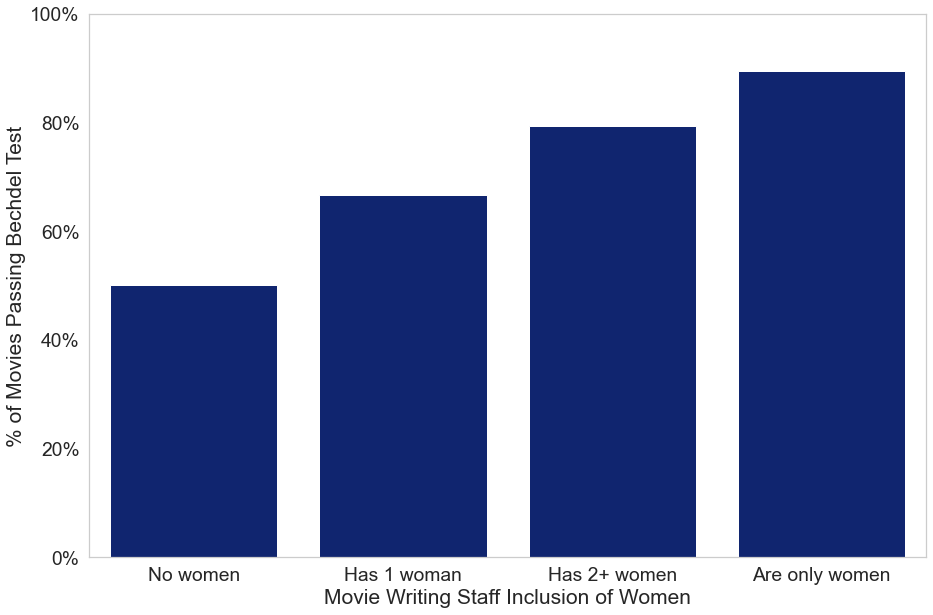

In [772]:
plot_pass_by_category(model_principals,'writer_female_flag',xlab = 'Movie Writing Staff Inclusion of Women');
plt.savefig("Inclusion of Women on Writing Staff.svg", format="svg")

print("INCLUSION OF WOMEN ON WRITING STAFF")

   director_female_flag bechdel pass       % of Movies Passing Bechdel Test  \
                                 sum count                                    
0  Has at least 1 woman          775   972                        79.732510   
1              No women         3657  6694                        54.631013   

  count  
         
0   972  
1  6694  
INCLUSION OF WOMEN ON DIRECTING STAFF


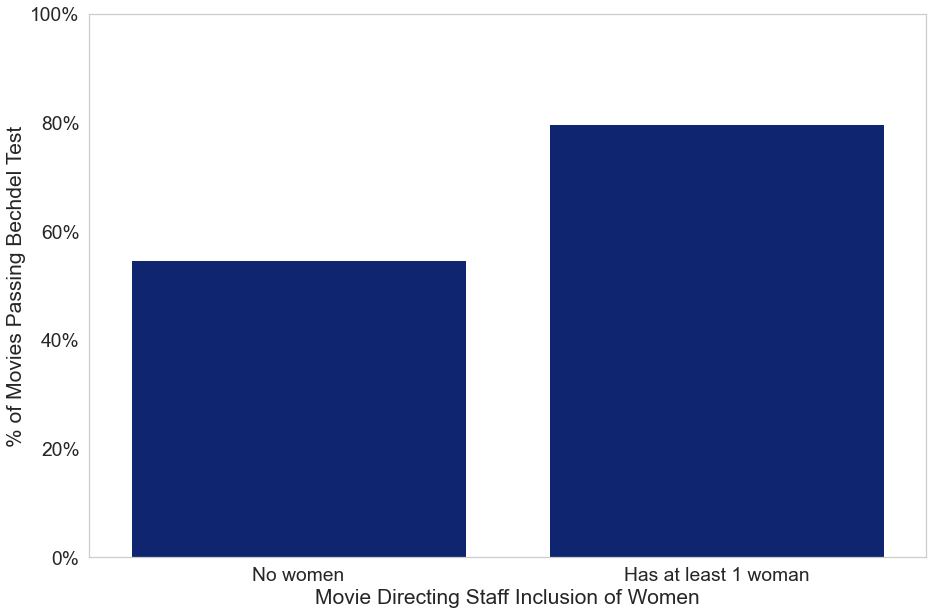

In [773]:
plot_pass_by_category(model_principals,'director_female_flag',xlab='Movie Directing Staff Inclusion of Women');
plt.savefig("Inclusion of Women on Directing Staff.svg", format="svg")
print("INCLUSION OF WOMEN ON DIRECTING STAFF")

   producer_female_flag bechdel pass       % of Movies Passing Bechdel Test  \
                                 sum count                                    
0                     0         2176  3639                        59.796647   
1  Has at least 1 woman           58    81                        71.604938   
2              No women         2198  3946                        55.701977   

  count  
         
0  3639  
1    81  
2  3946  
INCLUSION OF WOMEN ON PRINCIPAL PRODUCERS


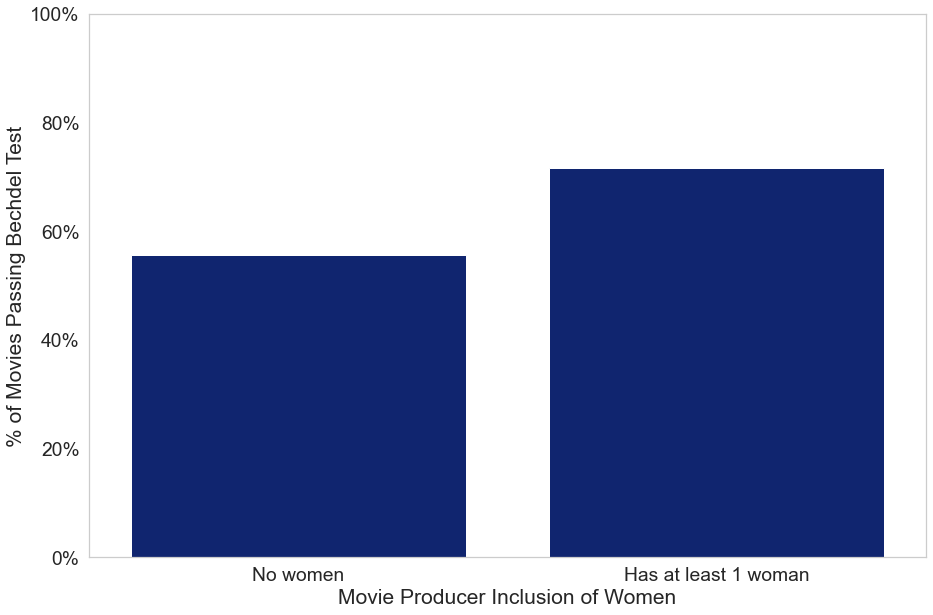

In [774]:
plot_pass_by_category(model_principals,'producer_female_flag', xlab='Movie Producer Inclusion of Women');
plt.savefig("Inclusion of Women on Principal Producers.svg", format="svg")
print("INCLUSION OF WOMEN ON PRINCIPAL PRODUCERS")

has top prod comp bechdel pass       % of Movies Passing Bechdel Test count
                             sum count                                       
0               0.0         2619  4420                        59.253394  4420
1               1.0         1813  3246                        55.853358  3246

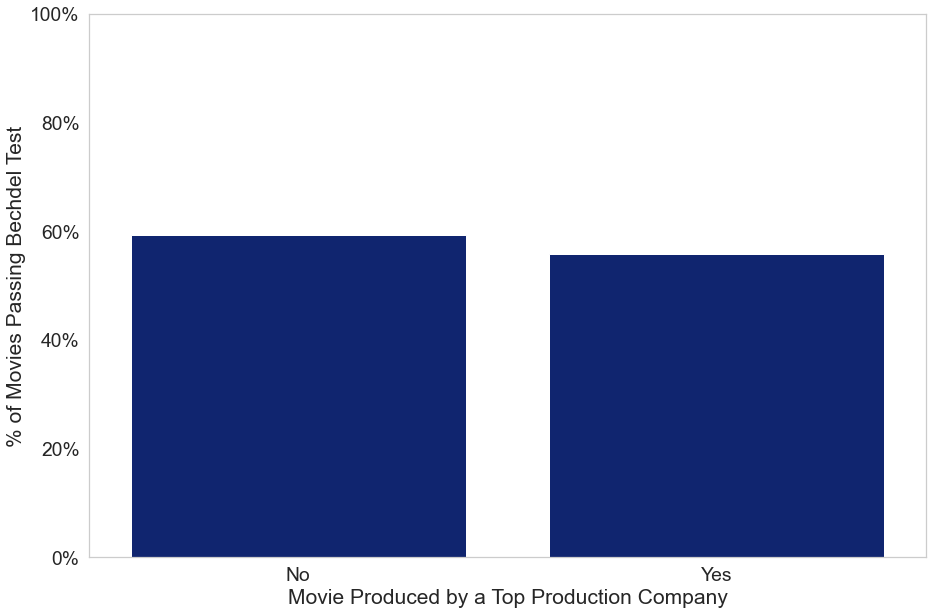

In [775]:
# plot_pass_by_category(model_principals,'has top prod comp',xlab='Movie Produced by a Top Production Company')

groupby = model_principals.groupby('has top prod comp').agg({'bechdel pass':['sum','count']}).reset_index()
groupby['% of Movies Passing Bechdel Test'] = groupby['bechdel pass']['sum']/groupby['bechdel pass']['count']*100
groupby['count'] = groupby['bechdel pass']['count']
sns.set_color_codes('dark')
g = sns.barplot(data = groupby, x='has top prod comp',y='% of Movies Passing Bechdel Test',color="b",)
g.set(ylim=(0,100),xlabel='Movie Produced by a Top Production Company')
g.set_xticklabels(labels=['No','Yes'])
g.yaxis.set_major_formatter(PercentFormatter())
plt.savefig("Top Production Company.svg", format="svg")
groupby

Ex-US and Top Prod Comp bechdel pass       % of Movies Passing Bechdel Test  \
                                   sum count                                    
0                     0.0         3991  6948                        57.440990   
1                     1.0          441   718                        61.420613   

  count  
         
0  6948  
1   718

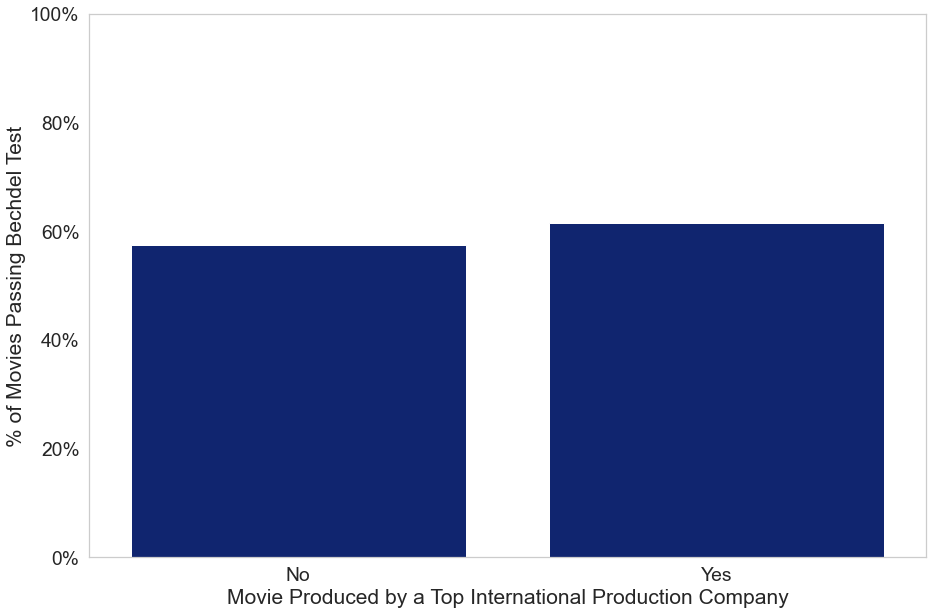

In [776]:
# plot_pass_by_category(model_principals,'Ex-US and Top Prod Comp')

groupby = model_principals.groupby('Ex-US and Top Prod Comp').agg({'bechdel pass':['sum','count']}).reset_index()
groupby['% of Movies Passing Bechdel Test'] = groupby['bechdel pass']['sum']/groupby['bechdel pass']['count']*100
groupby['count'] = groupby['bechdel pass']['count']
sns.set_color_codes('dark')
g = sns.barplot(data = groupby, x='Ex-US and Top Prod Comp',y='% of Movies Passing Bechdel Test',color="b",)
g.set(ylim=(0,100),xlabel='Movie Produced by a Top International Production Company')
g.set_xticklabels(labels=['No','Yes'])
g.yaxis.set_major_formatter(PercentFormatter())
plt.savefig("Top International Production Company.svg", format="svg")
groupby

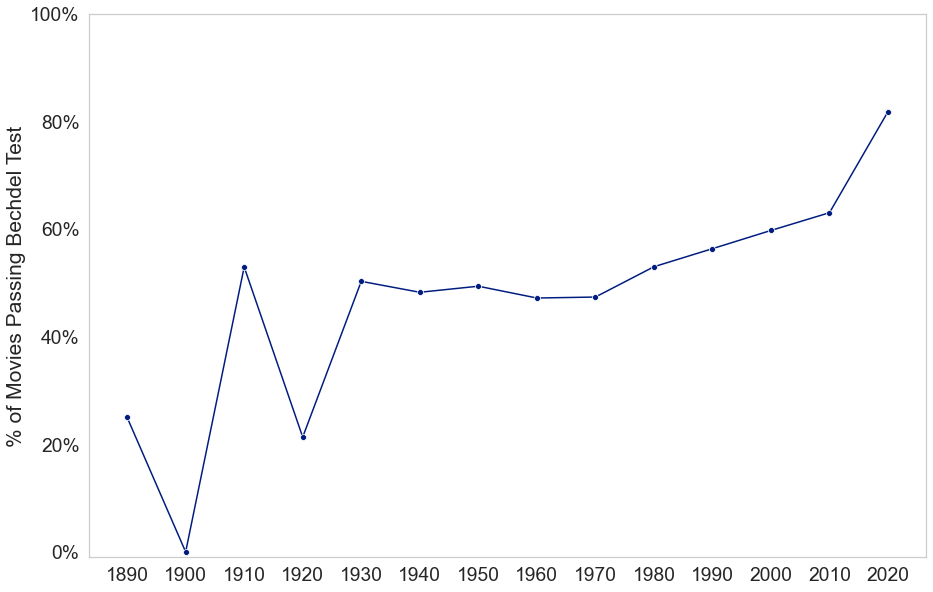

In [728]:
params = {'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
          
pylab.rcParams.update(params)

sns.set(font_scale=1.75)
sns.set_style("whitegrid", {'axes.grid' : False})

groupby = model_principals.groupby('decade').agg({'bechdel pass':['sum','count']}).reset_index()

groupby['% of Movies Passing Bechdel Test'] = groupby['bechdel pass']['sum']/groupby['bechdel pass']['count']*100
groupby['count'] = groupby['bechdel pass']['count']
sns.set_color_codes('dark')
g = sns.lineplot(data = groupby, x='decade',y='% of Movies Passing Bechdel Test',color="b",marker='o')
g.set(xticks=groupby['decade'].values,ylim=(-1,100),xlabel=None)
g.yaxis.set_major_formatter(PercentFormatter());
plt.savefig("Bechdel Test Over Time.svg", format="svg")

In [323]:
# f, axes = plt.subplots(5, 2, figsize=(7, 7), sharex=True)

# for var in ['writer_f_count', 'director_f_count', 'producer_f_count','editor_f_count', 'cast_f_count']:
#     print(model_principals[var].head())


hist_data = pd.melt(model_principals,id_vars=['imdbid_tt','bechdel pass'],
            value_vars=['writer_f_count', 'director_f_count', 'producer_f_count','editor_f_count', 'cast_f_count'],
            value_name='Count',
            var_name='Category')

hist_data['Category'] = hist_data['Category'].str.replace('_f_count',"")

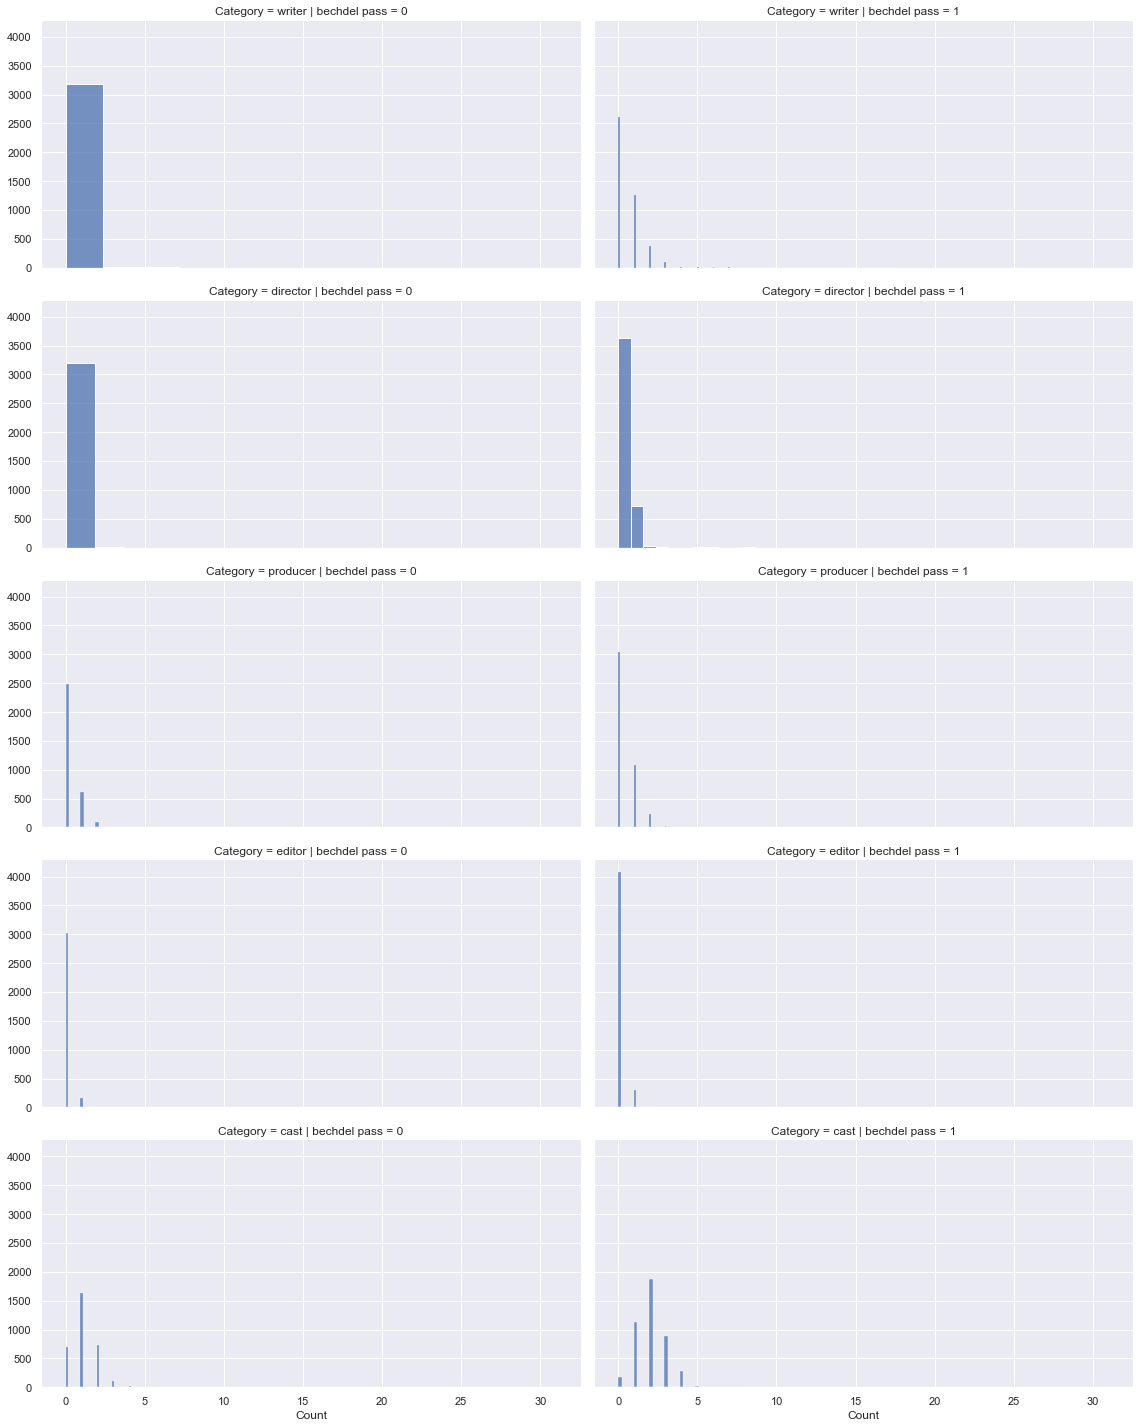

In [326]:
hist_g = sns.FacetGrid(hist_data, col='bechdel pass', row ='Category', sharex=True,height=4,aspect=2)
hist_g.map(sns.histplot,'Count')
# sns.displot(data=hist_data,,col='bechdel pass',row='Category',sharex=False);

# Appendix - Extras

### Can opt to get the dubious column from getMovieByImbdId on Bechdel Test Movie List

In [80]:
# %%time

# dubious_data = []
# error_ids = []
# for row in bechdel_movies['imdbid']:
#     response = requests.get('http://bechdeltest.com/api/v1/getMovieByImdbId?imdbid='+str(row))
#     data = response.json()
#     if str(row) == data['imdbid']:
#         print('Match found with',str(row))
#         dubious_dict = {}
#         dubious_dict['imdbid'] = data['imdbid']
#         dubious_dict['dubious'] = data['dubious']
#         dubious_data.append(dubious_dict)
#     else:
#         print('Error with',str(row))
#         error_ids.append(str(row))
        
# print(error_ids)        
# pd.DataFrame(dubious_data)

### Query movies by ID using imdbpy library

In [156]:
from imdb import IMDb
from imdb.helpers import makeTextNotes

In [ ]:
%%time
# create an instance of the IMDb class
ia = IMDb()

In [428]:
# help(ia)

In [429]:
# ia.get_movie_infoset()

In [ ]:
search = ia.search_movie('Shrek')
id_=search[0].getID()

In [ ]:
movie = ia.get_movie('0000003')

if 'production companies' in movie.keys():
    series = pd.Series(pd.Series(movie['production companies']).unique()).apply(lambda x:x['name']) + ","
    result = series.sum()
else:
    result = 'error'
    

In [217]:
ia.get_company('0002648')['name']

'Magnolia Mae Films'

In [176]:
ia.get_person_biography('0166380')

582 ms ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [168]:
top = ia.get_popular100_movies()
top[0].keys()

['rating',
 'title',
 'year',
 'votes',
 'popular movies 100 rank',
 'kind',
 'canonical title',
 'long imdb title',
 'long imdb canonical title',
 'smart canonical title',
 'smart long imdb canonical title']

In [169]:
for movie in top[:10]:
    print(movie['title'],movie['year'],movie.movieID)

The Dig 2021 3661210
The Little Things 2021 10016180
Palmer 2021 6857376
Finding 'Ohana 2021 10332588
Promising Young Woman 2020 9620292
Below Zero 2021 9845564
Godzilla vs. Kong 2021 5034838
Dara of Jasenovac 2020 10554232
Malcolm & Marie 2021 12676326
Bliss 2021 10333426


In [27]:
ia.get_person_infoset()

['awards',
 'biography',
 'filmography',
 'genres links',
 'keywords links',
 'main',
 'news',
 'official sites',
 'other works',
 'publicity']

In [ ]:
# movie_info = ['cast', 'genres', 'year', 'producers', 'editors', 'editorial department', \
#  'production managers', 'assistant directors', 'script department', 'writer', \
#  'director', 'production companies']

In [205]:
# API Approach
# person = ia.get_person('0617588',info=['biography'])
# words = person['mini biography'][0]
# words

# Webscraping approach
name_id = 'nm0166380'
url = "https://www.imdb.com/name/"+name_id+"/bio?ref_=nm_ov_bio_sm"
# try:
response = requests.get(url)
if response.status_code != 200:
    print('error: page not found with', name_id)
    pronoun_mode = 'error'
else:
    soup = BeautifulSoup(response.text)
    div = soup.find('div',class_='soda odd')
    print(div)
    if type(div) == type(None):
        print('bio not found with',name_id)
        pronoun_mode = "error"
    else:
        bio = div.text.strip()
        patt = re.compile(r"(he|his|him|she|her|it|its|they|their|them) ",re.IGNORECASE)
        matches = patt.findall(bio)
        if matches == []:
            print('pronouns not found in bio for',name_id)
            pronoun_mode = 'error - no pronouns'
        else:
            matches_series = pd.Series(matches).str.lower().value_counts().reset_index()
            matches_series.loc[matches_series['index'].str.contains('he|his|him'),'bio gender'] = 'male'
            matches_series.loc[matches_series['index'].str.contains('she|her'),'bio gender'] = 'female'
            matches_series.loc[matches_series['index'].str.contains('it|its|they|their|them'),'bio gender'] = 'nb'
            pronoun_mode = matches_series['bio gender'].value_counts().index[0]
# except Exception as e:
#     print(e)
#     pronoun_mode = 'error'
pronoun_mode

<div class="soda odd">
<p>
              François Clerc is an actor, known for <a href="/title/tt0000014">L'arroseur arrosé</a> (1895).<br/>
</p>
</div>
pronouns not found in bio for nm0166380


'error - no pronouns'

In [106]:
patt = re.compile(r"(he|she|it|they|his|her|their) ",re.IGNORECASE)
print(patt.findall(words))
# print(list(pd.Series(patt.findall(words)).str.lower().value_counts().index))

['he', 'he', 'His', 'he', 'he', 'he', 'he', 'he', 'he']


In [39]:
movie = ia.get_movie('0133093')
plot=movie['plot'][0]
plot

'When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth--the life he knows is the elaborate deception of an evil cyber-intelligence.'

In [29]:
print(movie['directors'])
print(movie['director'])


[<Person id:0905154[http] name:_Lana Wachowski_>, <Person id:0905152[http] name:_Lilly Wachowski_>]
[<Person id:0905154[http] name:_Lana Wachowski_>, <Person id:0905152[http] name:_Lilly Wachowski_>]


# Buggy code

### Pickle Imported Data

In [136]:
# for item in datasets_zip[:3]:
#     to_pickle =item[1] + '.pickle'
#     print(to_pickle)
#     with open(to_pickle, 'wb') as f:
#         pickle.dump(item[0], f, pickle.HIGHEST_PROTOCOL)

bechdel_movies.pickle
title_crew.pickle
title_basics.pickle


In [137]:
# for item in datasets_zip[3:]:
#     to_pickle =item[1] + '.pickle'
#     print(to_pickle)
#     with open(to_pickle, 'wb') as f:
#         pickle.dump(item[0], f, pickle.HIGHEST_PROTOCOL)

title_principals.pickle
title_akas.pickle
name_basics.pickle


### Load Pickle'd Data when returning to this notebook

In [139]:
db_dict = {}

In [140]:
# for item in datasets_zip[:3]:
#     from_pickle =item[1] + '.pickle'
#     print(from_pickle)
#     with open(from_pickle, 'rb') as f:
#         db_dict[item[1]] = pickle.load(f)

bechdel_movies.pickle
title_crew.pickle
title_basics.pickle


In [157]:
# for item in datasets_zip[3:]:
#     from_pickle =item[1] + '.pickle'
#     print(from_pickle)
#     with open(from_pickle, 'rb') as f:
#         db_dict[item[1]] = pickle.load(f)

# Appendix - Old Code

In [ ]:
# engine = create_engine('postgresql://postgres:warroo:localhost@localhost:5432/tennis')

# title_principals = pd.read_csv('title.principals.tsv',sep='\t')

# # I'm choosing to name this table "aus_men"
# title_principals.to_sql('title_principals', engine, index=False)